This notebook will be used with the aim of showing how KNN works:

# 1. Set up

# 2. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

import category_encoders as ce

# 3. Define global variables

In [2]:
INPUT_PATH = "../../data/credit_card_data/data_modified_binary_classification.csv"

# 4. Functions

# 5. Code

We are going to make use of some credit card details data. The data is calculated in the notebook *00_transform_data_binary_classification.ipynb*. All needed information about the data is sotred there.

We'll proceed the same way as with the logistic regression in order to give the reader consistency when reading these notebooks

## 5.1. Load and transform data

First of all we are going to load the both the data and the target variables making use of pandas library

In [3]:
data = pd.read_csv(INPUT_PATH, sep=";")
data.head()

,car_owner,propert_owner,children,type_income,education,marital_status,housing_type,employed_days,mobile_phone,work_phone,phone,email_id,family_members,target
0,Y,Y,0,Pensioner,Higher education,Married,House / apartment,365243,1,0,0,0,2,1
1,Y,N,0,Commercial associate,Higher education,Married,House / apartment,-586,1,1,1,0,2,1
2,Y,N,0,Commercial associate,Higher education,Married,House / apartment,-586,1,1,1,0,2,1
3,Y,N,0,Commercial associate,Higher education,Married,House / apartment,-586,1,1,1,0,2,1
4,Y,N,0,Pensioner,Higher education,Married,House / apartment,-586,1,1,1,0,2,1


### Train / test split

Before doing transformations in the data, we need to divide it into train and test. **Let's remember that all transformations must be fitted in the training dataset**

In [4]:
X = data.drop("target", axis=1)
y = data["target"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

We need to transform all categorical columns to numeric. First, let's detect them:

In [6]:
categorical_cols = data.select_dtypes(include="object").columns

We are going to use target encoder in order to transform the categorical data:

In [7]:
target_encoder = ce.TargetEncoder(cols = categorical_cols)

/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [8]:
X_train_processed = target_encoder.fit_transform(X_train, y_train)
X_test_processed = target_encoder.transform(X_test)

## 5.2. Training

Before training, we are going to make use of the *elbow method* in order to find the best value of k when training the algorithm:

In [9]:
list_scores = list()

In [10]:
for k in range(1, 21, 2):
    # Create a KNN with the current K value
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_processed, y_train)
    # Predict on the training data (assuming there's no separate validation set)
    y_pred = knn.predict(X_test_processed)
    accuracy = accuracy_score(y_test, y_pred)
    # Append the accuracy score to the scores list
    list_scores.append(accuracy)

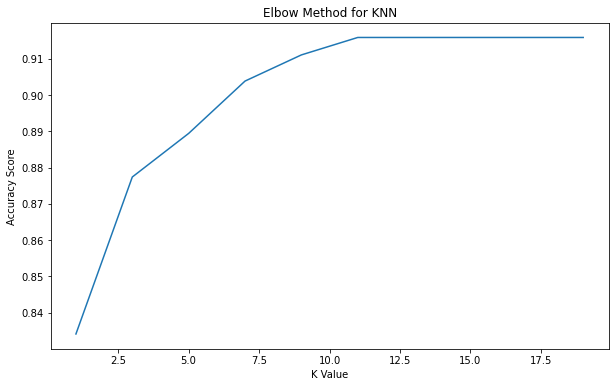

In [11]:
plt.figure(figsize=(10, 6))

sns.lineplot(x=range(1, 21, 2), y=list_scores)

plt.xlabel("K Value")
plt.ylabel("Accuracy Score")
plt.title("Elbow Method for KNN")
plt.show()

This plot tells us that a good value to choose should be **k=3** because the accuracy score starts to plateau around K=3. This suggests that **k=3** might be a good choice, as adding more neighbors beyond that point doesn't significantly improve the model's performance.

Now we can train our model with k=3:

In [12]:
model = KNeighborsClassifier(n_neighbors=3)

model.fit(X_train_processed, y_train)

KNeighborsClassifier(n_neighbors=3)

Once the model is trained, let's calculate predictions of the X_test_precessed data. Before calculating these predictions, we'll set the threshold to 0.1 as done in the logistic regression:

In [13]:
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
y_pred = np.where(y_pred_proba >= 0.1, 1, 0)

## 5.3. Metrics calculation

First, let's calculate some metrics and show them:

In [14]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [15]:
print(f"The accuracy error value is: {accuracy}")
print(f"The roc_auc value is: {roc_auc}")

The accuracy error value is: 0.7163461538461539
The roc_auc value is: 0.5400824896887889


Now we will plot both the confusion matrix and the roc curve:

**Confusion matrix:**

In [16]:
accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy error value is: {accuracy}")

The accuracy error value is: 0.7163461538461539


In [17]:
conf_matrix = confusion_matrix(y_test, y_pred, normalize="true")

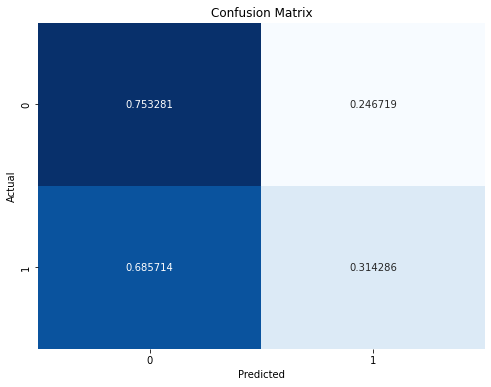

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can observe that the model is not detecting well the negative class instances, in fact, wrong detected ones are more than the good detected ones :S

**ROC Curve:**

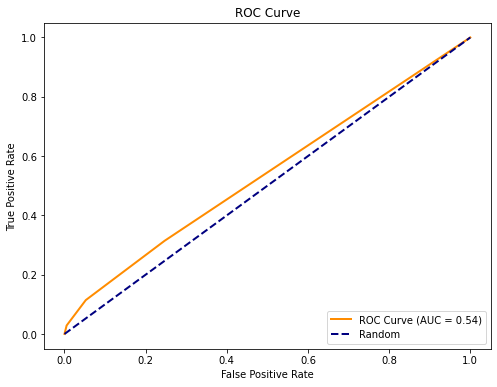

In [19]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {round(roc_auc, 2)})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

A 0.54 value in AUC is not a really good result. We will need to dive into more complex algorithms that give us better performance in the metric.

Let's see if we have model overfitting:

In [20]:
y_pred_proba_train = model.predict_proba(X_train_processed)[:, 1]

In [21]:
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train)
roc_auc_train

0.9115105719707237

WE HAVE A LOT OF OVERFITTING. In the real world this would have to be mitigated, touching hyperparameters or attending to the train/test split more carefuly. Since we are just "playing" we are not going to give more importance. In more advanced notebooks, we will go through how the overfitting can be mitigated